# Develop the R200 SHMR estimator

I will first develop the code then I'll will test on the SDSS data. This time, I use the critical density instead of the derivative approach.

In [1]:
import matplotlib.pyplot as plt
from astropy import units as u
import numpy as np

In [2]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.283)
Msol = 1.98847e33
Mpc2cm = 3.086e+24
z=0.1
rhoc = cosmo.critical_density(z)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
rhoc.to(u.Msun/u.Mpc**3)

<Quantity 1.48731815e+11 solMass / Mpc3>

## Develop r200SHMR Class

In [4]:
from scipy.interpolate import interp1d
### Compute R200c based on the HOD model
def computeR200(gals, cat, nbkg, rmax=3, defaultMass=1e14,testPz=False,compute=True):
    ## estimate R200
    ncls = len(cat)
    r200m = []

    for idx in range(ncls):
        cls_id, z_cls = cat['CID'][idx], cat['redshift'][idx]
        magLim_i = cat['magLim'][idx,1]

        gal = gals[(gals['CID']==cls_id)&(gals['mag'][:,2]<=magLim_i)]

        if compute:
            r200i = calcR200(gal['R'],np.ones_like(gal['PDFz']),cls_id,z_cls,nbkg[idx],rmax=rmax,testPz=testPz)
        else:
            r200i = 0.1

        r200i = checkR200(r200i,z_cls,M200=defaultMass)
        print('r200:',r200i)
        r200m.append(r200i)
    
    return np.array(r200m)

def calcR200(radii,pz,cls_id,z_cls,nbkg,rmax=3,testPz=False):
    ngals_cls, rbin = doRadialBin(radii,pz,width=0.1,testPz=testPz)

    ngals = ngals_cls-nbkg*np.pi*rbin**2
    ####params=[11.6,12.45,1.0,12.25,-0.69]#parameters for mass conversion - see table 4 in Tinker paper
    params = [11.59,12.94,1.01,12.48,-0.69]#parameters for mass conversion - see table 4 in Tinker paper
    mass = hod_mass_z(ngals,z_cls,params) #calculate mass given ngals (see above functions)

    volume = (4./3)*np.pi*rbin**3
    mass_density=(mass)/volume

    mass_density=np.where(mass_density<0.1,1e11,mass_density)
    pc=200*np.ones_like(radii)
    rho_crit = rhoc(0)
    critdense1 = crit_density(rho_crit,z_cls,0.23,0.77)
    critdense = critdense1*np.ones_like(rbin)

    X=2000 #desired excess over critical density, ex. if X=200, calculates R/M200
    dX=10  #acceptance window around X
    ratio=mass_density/critdense

    f=interp1d(rbin,ratio,fill_value='extrapolate')
    radii_new=np.linspace(0.1,rmax,10000)
    ratio_new=f(radii_new)
    r200m=radii_new[np.where( (ratio_new>=X-dX)&(ratio_new<=X+dX) )] #find possible r200s within acceptance range
    
    if r200m.size > 0:
        r200m=np.median(r200m) #mean of all possible r200s is measured r200

    else:
        ## Try r500
        X=500
        r200m=radii_new[np.where( (ratio_new>=X-dX)&(ratio_new<=X+dX) )] #find possible r200s within acceptance range
        
        if r200m.size > 0:
            r200m=np.median(r200m)/0.65 #mean of all possible r200s is measured r200
        else:
            r200m = 0
            print('bad cluster:',cls_id,'ratio min/max:',min(ratio_new),max(ratio_new))

    return r200m

def convertM200toR200(M200,rho,delta=200):
    ## M200 in solar masses
    ## R200 in Mpc
    R200 = ( M200/(delta*4*np.pi*rho/3) )**(1/3.)
    return R200*0.7

def compute_kde(x,weights,bw=None):
    Norm = np.nansum(weights)
    pdf = gaussian_kde(x, weights=weights, bw_method=bw)
    return pdf, Norm


In [35]:
from halotools.empirical_models import PrebuiltHodModelFactory
from scipy.integrate import simps

### Define Cosmology
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
H0 = 70
cosmo = FlatLambdaCDM(H0=H0, Om0=0.283)

class r200SHMR:
    """This class estimates r200c of a cluster
    """
    def __init__(self, rbins, model_name='leauthaud11', z=0, sigma_bg=0) -> None:
        """__init__ start the r200c estimator 

        Define the radial binning scheme, the redshift and the background density

        Parameters
        ----------
        rbins : array
            radial bins used on the computation
        model_name: str, optional
            stellar-to-halo mass relation model name following prebuiltHaloFactory
        z : int, optional
            redshift of the cluster, by default 0
        sigma_bg : int, optional
            bagrkound density, no contamination by defalt
        fmasked : int, optional
            masked area fraction, by default 0
        """
        #print(4*'-----')
        #print('R200c: Stellar to Halo Mass Estimator')
        
        # define radial bins
        self.rbins = rbins
        self.rmed = 0.5*(rbins[1:]+rbins[:-1])
        self.area = np.pi*self.rmed**2
        self.volume = 4*np.pi*self.rmed**3/3
        
        # define other variables
        self.sigma_bg = 10**sigma_bg
        self.z = z
        
        # define stellar-to-halo mass relation model
        self.model_name = model_name
        
        # compute the universe critical density at redshift z
        self._init_critical_density()
        pass
    
    def fit(self, mstar, radii, bias=0.0):
        """fits the radii with 200 the critical density of the universe

        Parameters
        ----------
        mstar : array
            galaxies stellar masses
        radii : array
            galaxies cluster centric distance
        """        
        # compute cumulative cluster stellar mass, note the background is subtracted.
        self.compute_stellar_mass_density(mstar, radii)
        
        # stellar mass thresholds
        log_ms_low, log_ms_hig = np.nanpercentile(mstar, [0, 100])

        # predict halo mass as a function of radii using the stellar to halo mass relation
        self.compute_halo_mass(self.model_name, log_ms_low, log_ms_hig)
        
        # fit r200c based on the critical density of the unvierse
        self.compute_r200c(delta=200,bias=bias)
        pass
    
    
    def compute_r200c(self, bias=0, delta=200, th=0.015, window=10):
        """compute_r200c
        
        function under construction
        
        # for instance, r200 is the distance associated with the total halo mass
        take the derivative point.

        Parameters
        ----------
        delta : int, optional
            delta times the critical density of the universe, eg. 200 rho_c, by default 200
        """
        self.shmr_halo_mass = self.shmr_halo_mass-bias
        #self.fit_halo_mass_poly_derivative(bias)
        self.fit_critical_density()
        #self.r200c = convertM200toR200(10**self.haloMax, self._rhoc, delta=delta)/(H0/100.)
        pass
    
    def fit_critical_density(self, rmax=8):
        self.shmr_mass_density = (10**self.shmr_halo_mass)/self.area
        critdense = self._rhoc*np.ones_like(self.rmed)

        X=200 #desired excess over critical density, ex. if X=200, calculates R/M200
        dX=10  #acceptance window around X
        ratio = self.shmr_mass_density/critdense

        f = interp1d(self.rmed,ratio,fill_value='extrapolate')
        radii_new = np.linspace(0.1,rmax,10000)
        ratio_new = f(radii_new)
        r200m=radii_new[np.where( (ratio_new>=X-dX)&(ratio_new<=X+dX) )] #find possible r200s within acceptance range

        if r200m.size > 0:
            r200m=np.median(r200m) #mean of all possible r200s is measured r200

        else:
            ## Try r500
            X=500
            r200m=radii_new[np.where( (ratio_new>=X-dX)&(ratio_new<=X+dX) )] #find possible r200s within acceptance range

            if r200m.size > 0:
                r200m=np.median(r200m)/0.65 #mean of all possible r200s is measured r200
            else:
                r200m = 0.
                
        self.m200c = np.interp(r200m, self.rmed, self.shmr_halo_mass)
        self.r200c = r200m

    def fit_halo_mass_poly_derivative(self, bias=0.):
        sm = smoothP(self.rmed, self.shmr_halo_mass, 5, deriv=0)
        d1 = smoothP(self.rmed, self.shmr_halo_mass, 5, deriv=1)
        d2 = smoothP(self.rmed, self.shmr_halo_mass, 5, deriv=2)

        if np.min(d1)>0:
            m200c = interp1d(d1, sm)(np.min(d1))
        elif d2[0]>0:
            m200c = interp1d(d2, sm, fill_value='extrapolate')(0) 
        else:
            m200c = interp1d(d1, sm, fill_value='extrapolate')(0) 

        r200c = interp1d(sm, self.rmed, fill_value='extrapolate')(m200c) 
        #r200c = convertM200toR200(10**m200c, self._rhoc, delta=200)#/(H0/100.)
        self.r200c = r200c
        self.m200c = m200c
        
    def compute_stellar_mass_density(self, mstar, radii):
        """compute stellar mass density a given aperture

        Parameters
        ----------
        mstar : array
            galaxy stellar mass
        radii : array
            cluster centric distance
        """
        # compute the total surface stellar mass density
        smass_density_total = self.compute_density(radii, 10**mstar)
        smass_cum_total = np.cumsum(smass_density_total,axis=0)
        
        
        # compute the cumulative stellar mass inside R subtracted by the backround
        self.smass_cluster = np.log10(smass_cum_total - self.sigma_bg*self.area)
        self.smass_density_cluster = (smass_density_total - self.sigma_bg)#*self.area/self.volume
    
    def compute_halo_mass(self, model_name, log_ms_low=10., log_ms_hig=12.5, nbins=50):
        """compute_halo_mass based on the stellar-to-halo mass relation (SHMR)
        
        We assume the SHMR parameters from Sunecsh et al. 2022 fited on the COSMOS2020 dataset.
        Following HOD parametrization from Leauthaud et al. 2011 with no redshift evolution.
        """
        # define binning scheme
        self.bin_halo_mass = np.logspace(11.5, 17.0, nbins+25)
        self.bin_log_stellar_mass = np.linspace(log_ms_low, log_ms_hig, nbins)

        # compute cluster stellar mass
        self.shmr_total_cluster_stellar_mass(model_name)
        
        # predict halo mass
        self.shmr_halo_mass = np.log10(np.interp(10**self.smass_cluster, self.shmr_total_smass, self.bin_halo_mass))
    
    def shmr_total_cluster_stellar_mass(self, model_name):
        # compute Ntot = Nsat+Ncen as function of stellar and halo mass
        self.shmr_cen_sat_stellar_mass(model_name)
        
        # compute cluster stellar mass as a function of halo mass
        self.shmr_cumulative_stellar_mass()
        pass
    
    def shmr_cen_sat_stellar_mass(self, model_name):
        mean_ncen_smass = np.ones((self.bin_log_stellar_mass.size, self.bin_halo_mass.size))
        mean_nsat_smass = np.ones((self.bin_log_stellar_mass.size, self.bin_halo_mass.size))
        for i,logMt in enumerate(self.bin_log_stellar_mass):
            model = PrebuiltHodModelFactory(model_name, threshold = logMt,
                                            redshift=self.z, haloprop_key='halo_mvir')
            mean_ncen_smass[i] = model.mean_occupation_centrals(prim_haloprop = self.bin_halo_mass)
            mean_nsat_smass[i] = model.mean_occupation_satellites(prim_haloprop = self.bin_halo_mass)
            
        ## predicted number of galaxies (haloMass, stellarMass)
        self.shmr_ntot = mean_ncen_smass+mean_nsat_smass
        pass
    
    def shmr_cumulative_stellar_mass(self):
        # self.shmr_ntot number of central+number of satelites as a function of stellar mass and halo mass
        
        # compute total stellar mass as a function of halo mass
        total_smass = simps(self.shmr_ntot, x=10**self.bin_log_stellar_mass, axis=0) 
        total_smass-= (self.shmr_ntot[-1]*10**self.bin_log_stellar_mass[-1] -self.shmr_ntot[0]*10**self.bin_log_stellar_mass[0])
        
        # total cluster stellar mass as a function of halo mass 
        self.shmr_total_smass = total_smass
        pass
            
    def _init_critical_density(self):
        """compute critical stellar mass of the universe

        $M_{\star,c}$ is based on the critical density. 
        For a given volume, we can associate a critical halo mass.
        For this critical halo mass we assume a stellar to halo mass relation and compute the critical stellar mass of the universe.
        """
        self._rhoc = (cosmo.critical_density(self.z).to(u.Msun/u.Mpc**3)).value # Msun/Mpc^3
            
    def compute_density(self, x, weights):
        """compute radial density

        Parameters
        ----------
        x : array
            x-variable to compute the profile
        weights : array
            cumulative sum of the weights
        """
        return np.histogram(x, weights=weights, bins=self.rbins)[0]

    def compute_density_kde(self, x, weights,bw=0.2):
        """compute radial density

        Parameters
        ----------
        x : array
            x-variable to compute the profile
        weights : array
            cumulative sum of the weights
        """
        p, N = compute_kde(x,weights)
        
        return np.cumsum(p(self.rmed)*N*bw)
    



In [6]:
def smoothP(x,y, window=3, deriv=0):
    idx = np.isfinite(x) & np.isfinite(y)
    coefs = np.polyfit(x[idx], y[idx], deg=window)
    xnew = np.arange(0., 4., 100)
    if deriv==0:
        return np.poly1d(coefs)(x)
    else:
        return np.poly1d(coefs).deriv(deriv)(x)


## Validate on SDSS

Note the redshift catalog from the SDSS redshift sample is not complete in the cluster regions. There's an issue with the fiber colision.

In [7]:
import sys
sys.path.append('/Users/jesteves/Documents/GitHub/galaxyFormation/scripts')
from file_loc import FileLocs

In [8]:
fl = FileLocs(dataset='sdss', root='/Users/jesteves/Documents/GitHub/galaxyFormation/data/')
cat = fl.load_catalogs('cluster/main')
gal0 = fl.load_catalogs('galaxy/main')

mask  = (gal0['VLOS_MASK']).astype(bool)
mask &= gal0['VOLUME_LIM_MASK'].astype(bool)
gal = gal0[mask]

Loading Catalog: /Users/jesteves/Documents/GitHub/galaxyFormation/data/catalogs/SDSS/groupCatalog_Yang_deCarvalho2017.csv
Loading Catalog: /Users/jesteves/Documents/GitHub/galaxyFormation/data/catalogs/SDSS/groups_deCarvalho2017_5xR200m_galaxies_johnnyheq_pp.csv


### No Contamination

In [9]:
mask = np.where(gal['orbital']=='False',False, True)
mask &= gal['Rc']<=1.
gid = gal['Yang'][mask]
smass = gal['mass'][mask]
radii = gal['Rc'][mask]

In [10]:
cat#[10:]

Yang,RA,DEC,redshift,N200,logM200c,logM200m,R200c,R200m,thetaR200,thetaR200m,vcirc_c,vcirc_m
int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64
2,240.5602,16.1113,0.035999998450279236,525,15.444902420043945,15.61043080796355,2.8714284896850586,3.880159897239745,0.7795811316295294,1.0534475724189225,2041.7840576171875,1887.7175813096123
4,247.1149,40.8317,0.029999999329447746,217,14.814902305603027,14.988838641010085,1.7714285850524902,2.4220034873237517,0.5730670271152717,0.7835316364742502,1257.8946533203125,1168.0954840010763
5,247.1633,39.4674,0.029999999329447746,277,14.9649019241333,15.138926939889993,2.0,2.7177167877362454,0.6470111436516279,0.8791965384498562,1411.3817138671875,1310.7135159645927
6,167.6936,28.5374,0.032999999821186066,167,14.754902839660645,14.927840689026137,1.6857142448425293,2.3045122256737995,0.4975147606695648,0.6801442623443363,1201.785400390625,1116.2906247336416
7,351.1194,14.6251,0.041999999433755875,106,14.664902687072754,14.835094504183962,1.571428656578064,2.127630582418425,0.36826592735879554,0.4986124388818472,1122.9947509765625,1044.1083602597816
8,239.5372,27.3133,0.09000000357627869,183,15.254901885986328,15.411329095121902,2.442857265472412,3.1653055595608754,0.28232277514615234,0.3658166554840595,1778.5684814453125,1661.893369756073
...,...,...,...,...,...,...,...,...,...,...,...,...
625,242.3892,53.0522,0.06300000101327896,22,14.454901695251465,14.618135149740072,1.3285714387893677,1.76567550925269,0.2126872311457515,0.28266198128345965,958.7020263671875,892.8090091625098
628,325.7397,-6.8996,0.05400000140070915,40,14.494901657104492,14.660616473488858,1.3714286088943481,1.839771927974334,0.25348939806987825,0.34005610630577116,987.310546875,918.4862740091069


## Intrisec Error

In [11]:
# all galaxies inside r200c
keys = [np.where(gid==cid)[0] for cid in np.array(cat['Yang'])]

In [12]:
nobjects = []
r200p, m200p = [], []
for idx in keys:
    rbins = np.percentile(radii[idx], np.linspace(0,100,11))
    rModel = r200SHMR(rbins, model_name='zu_mandelbaum15' , sigma_bg=0)
    rModel.fit(smass[idx],radii[idx], bias=-0.324)
    nobjects.append(idx.size)
    
    m200c = np.log10(interp1d(rModel.shmr_total_smass, rModel.bin_halo_mass)(np.sum(10**smass[idx])))
    r200p.append(rModel.r200c)
    m200p.append(rModel.m200c)
    
r200p = np.array(r200p)
m200p = np.array(m200p)
nobjects = np.array(nobjects)

/usr/local/anaconda/lib/python3.8/site-packages/halotools/empirical_models/factories/prebuilt_model_factory.py:258: UserWarning: This particular model is still being tested in collaboration with Ying Zu.
If you need to use this prebuilt model for science, 
you will either need to test it yourself 
or wait for the Halotools developers to finish science verification.

  warn(under_development_warning.format("Ying Zu"))


In [13]:
r200c = np.array(cat['R200c'])
m200c = np.array(cat['logM200c'])
redshift = np.array(cat['redshift'])

In [14]:
bias = np.median(m200p-m200c)
bias

0.06838970354714036

In [15]:
def convertM200toR200_z(M200,z,delta=200):
    ## M200 in solar masses
    ## R200 in Mpc
    rhoc = (cosmo.critical_density(z).to(u.Msun/u.Mpc**3)).value # Msun/Mpc^3
    R200 = ( M200/(delta*4*np.pi*rhoc/3) )**(1/3.)
    return R200

r200p2 = convertM200toR200_z(10**(m200p-bias), redshift)

(12.35, 15.8)

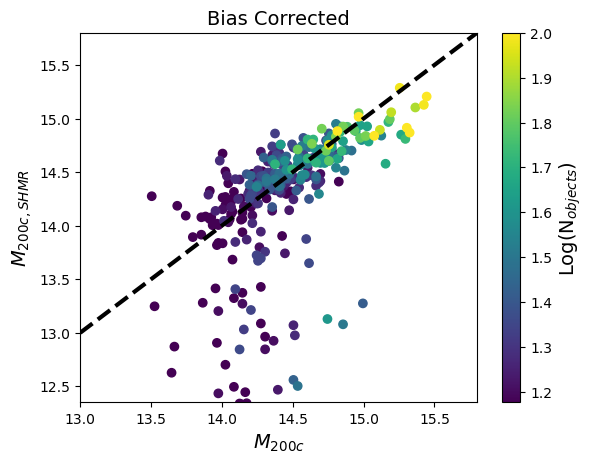

In [16]:
mmin, mmax = 13., 15.8
ix = np.argsort(nobjects)
plt.plot([mmin, mmax],[mmin, mmax],'k--',lw=3)
plt.scatter(m200c[ix], m200p[ix]-bias, c=np.log10(nobjects[ix]), vmin=np.log10(15), vmax=np.log10(100))
plt.colorbar().set_label('Log(N$_{objects}$)',fontsize=14)
plt.xlabel(r'$M_{200c}$',fontsize=14)
plt.ylabel(r'$M_{200c,SHMR}$',fontsize=14)
plt.title('Bias Corrected',fontsize=14)
plt.xlim(mmin,mmax)
plt.ylim(mmin-0.65,mmax)

(0.25, 3.5)

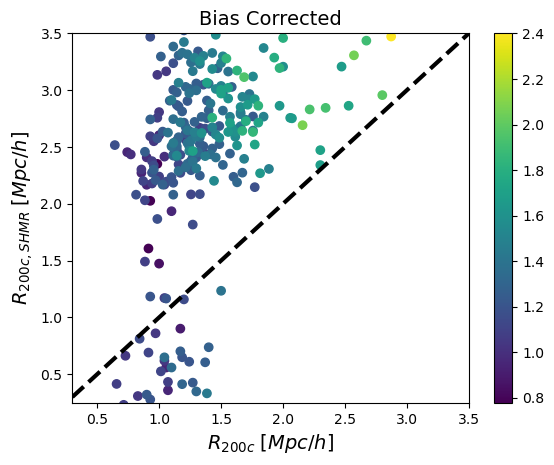

In [17]:
rmin, rmax = 0.3, 3.5
ix = np.argsort(nobjects)
plt.plot([rmin, rmax],[rmin, rmax],'k--',lw=3)
plt.scatter(r200c[ix], r200p[ix]/0.7/0.7, c=np.log10(nobjects[ix]))
plt.colorbar()
plt.xlabel(r'$R_{200c} \; [Mpc/h]$',fontsize=14)
plt.ylabel(r'$R_{200c,SHMR}\; [Mpc/h]$',fontsize=14)
plt.title('Bias Corrected',fontsize=14)
plt.xlim(rmin,rmax)
plt.ylim(rmin-0.05,rmax)

0.2673250476078089


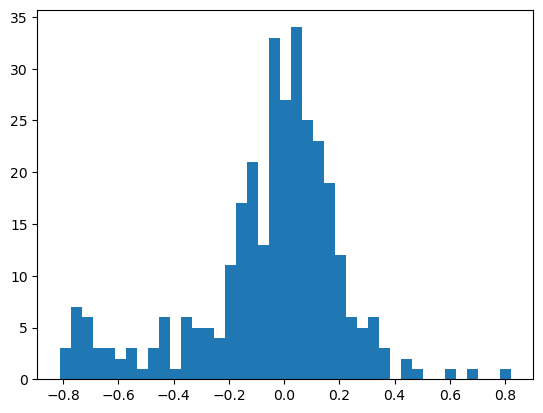

In [18]:
res = (r200p2-r200c)/r200c
nmask = np.abs(res)<1.

print(np.std(res[nmask]))
_ = plt.hist(res[nmask],bins=41)

Text(0.5, 1.0, 'True SHRM ')

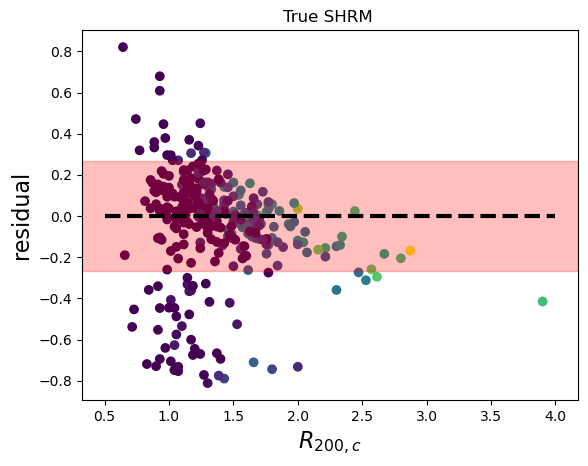

In [19]:
plt.plot([0.5, 4.],[0, 0],'k--',lw=3)
plt.scatter(r200c[nmask], res[nmask], c=np.log10(nobjects)[nmask],vmin=np.log10(20),vmax=np.log10(200))
plt.axhspan(-1*np.std(res[nmask]), 1*np.std(res[nmask]), alpha=0.25, color='r')
# plt.xscale('log')
plt.xlabel('$R_{200,c}$',fontsize=16)
plt.ylabel('residual',fontsize=16)
plt.title('True SHRM ')

Text(0.5, 0, 'redshift')

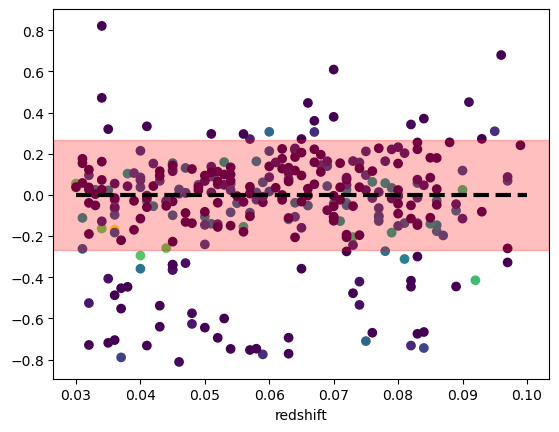

In [20]:
plt.plot([0.03, 0.1],[0, 0],'k--',lw=3)
plt.scatter(redshift[nmask], res[nmask], c=np.log10(nobjects)[nmask],vmin=np.log10(20),vmax=np.log10(200))
plt.axhspan(-1*np.std(res[nmask]), 1*np.std(res[nmask]), alpha=0.25, color='r')
# plt.xscale('log')
plt.xlabel('redshift')

There is an intrisic error with R200c. 

### With Contamination

In [21]:
def compute_background_denstiy(idx):
    x = rm[idx]
    y = 10**smass[idx]
    rb = np.percentile(x,[0,100])
    area = np.pi*(np.max(rv[idx])**2 - np.min(rv[idx])**2)
    sigmabg = np.log10(np.sum(y)/area)
    
    sigmabg = np.where(np.isfinite(sigmabg),sigmabg,10.3)
    #sigmabg = np.log10(np.sum(10**smass[field]/(area[field])))
    print('Stellar Mass Background Density Contamination %.2f [M$_{\odot}$/Mpc^2]'%(sigmabg))
    return sigmabg

In [22]:
gid = gal['Yang']
smass = gal['mass']
rm = gal['Rm']
rv = (gal['Rm']*gal['R200m'])

orbitall = np.where(gal['orbital']=='False',False, True)
interlopers = np.where(gal['interlopers']=='False',False, True)
infall = np.where(gal['infall']=='False',False, True)

field = (interlopers)#|(infall)

In [23]:
keys_bkg = [np.where((gid==cid) & (rm<=4) & (rm>3) & field)[0] for cid in np.array(cat['Yang'])]
sigma_bkg = np.array([compute_background_denstiy(ix) for ix in keys_bkg])


Stellar Mass Background Density Contamination 10.49 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.26 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.21 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.44 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 9.75 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.72 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.82 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.27 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 9.81 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 9.67 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.49 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 9.99 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.44 [M$_{\odot}$/Mpc^2]
Stellar Mass Background Density Contamination 10.14 [M$_{\odot}$/Mpc

In [24]:
# # mask = np.where(gal['orbital']=='False',False, True)
# rlower, rupper = 6, 8
# mask = (gal['Rm']*gal['R200m'])<=rupper

# gid = gal['Yang'][mask]
# smass = gal['mass'][mask]
# # radii = gal['Rc'][mask]
# rvalue = (gal['Rm']*gal['R200m'])[mask]
# radii = rvalue

# orbitall = np.where(gal['orbital'][mask]=='False',False, True)
# interlopers = np.where(gal['interlopers'][mask]=='False',False, True)
# infall = np.where(gal['infall'][mask]=='False',False, True)

# field = (interlopers)|(infall)
# field&= (radii>rlower)

# area = rvalue*(rupper**2-rlower**2)

# sigmabg = np.log10(np.sum(10**smass[field]/(area[field])))
# print('Stellar Mass Background Density Contamination %.2f [M$_{\odot}$/Mpc^2]'%(sigmabg))

In [25]:
cat.sort('logM200c')
cat

Yang,RA,DEC,redshift,N200,logM200c,logM200m,R200c,R200m,thetaR200,thetaR200m,vcirc_c,vcirc_m
int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64
564,194.921,38.8014,0.03400000184774399,22,13.504902839660645,13.656455704815503,0.6428571343421936,0.8676884242670865,0.18436639760878068,0.24884625619278217,460.49102783203125,420.91304090456134
193,156.7968,11.016,0.03200000151991844,27,13.524901390075684,13.67725249411392,0.6571428775787354,0.8833583291090673,0.19977223464357372,0.26854201073283285,467.4830322265625,427.2717814196957
234,41.6991,-0.5708,0.0430000014603138,21,13.644901275634766,13.797614944006858,0.7142857313156128,0.958634630719179,0.16369177846397573,0.2196888506394106,513.3801879882812,471.1154405597573
390,231.4995,48.4927,0.03700000047683716,21,13.664901733398438,13.819192468567438,0.7285714149475098,0.9802823302509792,0.19268390466931265,0.25925341455332773,520.8800048828125,477.6030033217431
235,233.8795,25.225,0.03400000184774399,23,13.68490219116211,13.84019471676957,0.7428570985794067,0.9991027191260603,0.2130456128439058,0.28653484851610667,528.7141723632812,484.661719485979
120,170.5107,34.3465,0.03500000014901161,34,13.744901657104492,13.901244328857658,0.771428644657135,1.0460205128958802,0.21517107043551142,0.29176174288812706,553.709716796875,508.1576702118204
...,...,...,...,...,...,...,...,...,...,...,...,...
26,258.2267,64.0514,0.08100000023841858,150,15.294901847839355,15.452727487036949,2.528571367263794,3.2947002574800357,0.32139699993550314,0.4187766965514693,1831.5782470703125,1708.4498092257656
47,241.306,16.4602,0.04399999976158142,232,15.304902076721191,15.471677995199613,2.5714285373687744,3.461449033114817,0.5765699657760479,0.7761318457776841,1835.83642578125,1703.5562271467647


In [26]:
# cat[np.where( (np.abs(res)>0.2) & (r200c>2.1))[0]]

In [36]:
# for a given cluster
cid = 2
# cid = 235
idx = np.where(gid==cid)[0]
zcls = float(cat['redshift'][cat['Yang']==cid])
m200c = float(cat['logM200c'][cat['Yang']==cid])
r200c = float(convertM200toR200_z(10**m200c, zcls))
sbg = float(sigma_bkg[cat['Yang']==cid])

In [37]:
# dx = 0.25
# rbins = np.arange(0., 5+dx, dx)
nbins = int(np.count_nonzero(rv[idx]<=5.)/5.)+1
rbins = np.percentile(rv[idx][rv[idx]<=5.], np.linspace(0,100,nbins))
rbins[0] = 0
# print(rbins)
# rbins = np.logspace(-4, np.log10(4), 16)

# rbins = np.percentile(radii[idx], np.linspace(0,100,21))
rModel = r200SHMR(rbins, model_name='zu_mandelbaum15', z=zcls, sigma_bg=0)
rModel.fit(smass[idx],rv[idx],bias=0.14)

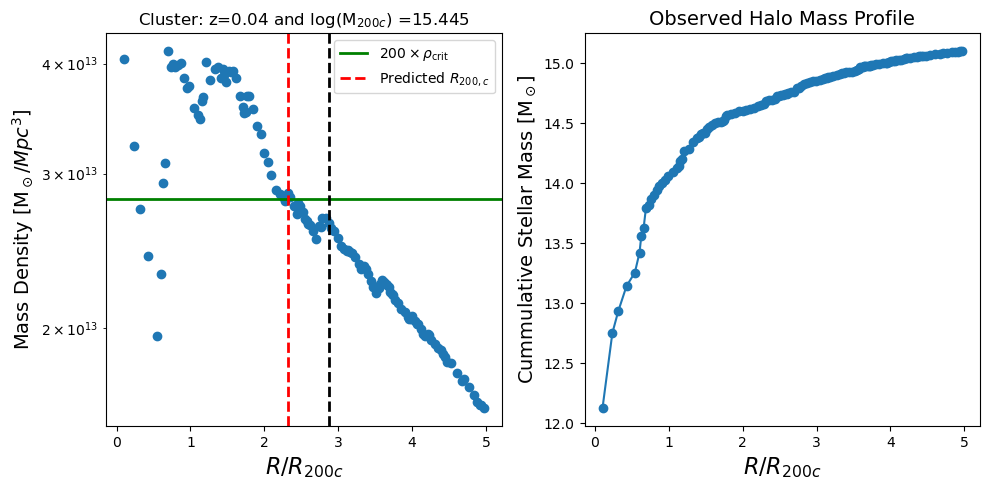

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(rModel.rmed, rModel.shmr_mass_density)

plt.axhline(200*rModel._rhoc,color='g',lw=2,label=r'$200 \times \rho_{\rm crit}$')
plt.axvline(r200c,color='k',ls='--',lw=2)
# plt.axhline(10**m200c,color='k',ls='--',lw=2,label='True $M_{200,c}$')

plt.axvline(rModel.r200c,color='r',ls='--',lw=2,label='Predicted $R_{200,c}$')
# plt.axhline(10**rModel.m200c,color='r',ls='--',lw=2,label='True $M_{200,c}$')


plt.yscale('log')
plt.xlabel(r'$R/R_{200c}$', fontsize=16)
plt.ylabel(r'Mass Density [M$_\odot/Mpc^3$]',fontsize=14)
plt.title('Cluster: z=%.2f and log(M$_{200c}$) =%.3f'%(zcls, m200c))
plt.legend()


plt.subplot(1,2,2)
# plt.loglog()
plt.scatter(rModel.rmed, rModel.shmr_halo_mass)
plt.plot(rModel.rmed, rModel.shmr_halo_mass)
plt.xlabel(r'$R/R_{200c}$', fontsize=16)
plt.ylabel(r'Cummulative Stellar Mass [M$_\odot$]',fontsize=14)
plt.title('Observed Halo Mass Profile',fontsize=14)
plt.tight_layout()

# plt.suptitle('SDSS')
# plt.title('Cluster: z=%.2f and log(M$_{200c}$) =%.3f'%(zcls, m200c))

In [39]:
# based on whiteboard equation

self = rModel

In [40]:
rhoc200 = 200*self._rhoc/1e13
print(f'200 times critical density: {rhoc200:.3f} $10^13 M_\odot/Mpc^3$')

200 times critical density: 2.806 $10^13 M_\odot/Mpc^3$


In [41]:
# critical halo mass
fmissing = 0.0
Mch = 1e13*rhoc200*rModel.area*(1-fmissing)

(0.0, 5.01)

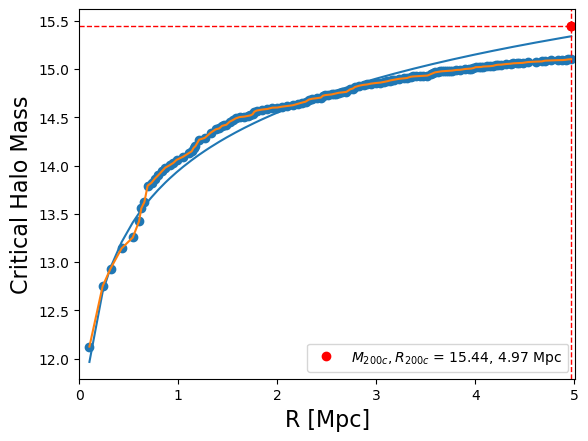

In [42]:
# plt.loglog()
r13p5 = np.interp(m200c, np.log10(Mch), self.rmed)

plt.plot(self.rmed, np.log10(Mch))
plt.plot([r13p5,r13p5],[m200c,m200c],'ro',label=r'$M_{200c}, R_{200c}$ = %.2f, %.2f Mpc'%(m200c, r13p5))
plt.axvline(r13p5,ls='--',lw=1,color='r')
plt.axhline(m200c,ls='--',lw=1,color='r')
plt.legend()

plt.scatter(rModel.rmed, rModel.shmr_halo_mass)
plt.plot(rModel.rmed, rModel.shmr_halo_mass)

plt.xlabel('R [Mpc]',fontsize=16)
plt.ylabel(r'Critical Halo Mass',fontsize=16)
plt.xlim(0., 5.01)

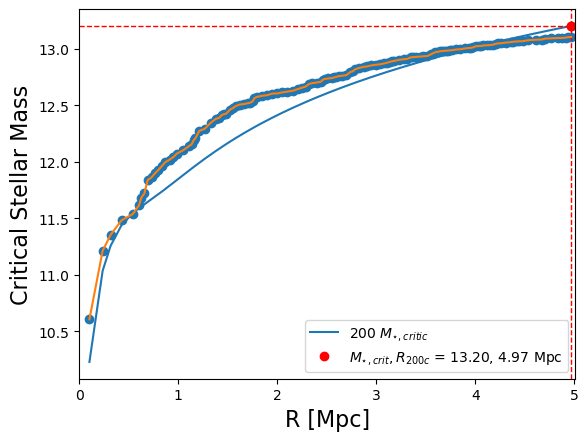

In [43]:
# what is the light to mass ratio?
stellar_to_halo_mass_ratio = interp1d(self.bin_halo_mass, self.shmr_total_smass, fill_value='extrapolate')
Msc = stellar_to_halo_mass_ratio(Mch)

# plt.loglog()
plt.plot(self.rmed, np.log10(Msc),label=r'200 $M_{\star,critic}$')

M0p5Mpc =np.interp(r13p5, self.rmed, np.log10(Msc))
plt.plot([r13p5,r13p5],[M0p5Mpc,M0p5Mpc],'ro',
         label=r'$M_{\star,crit}, R_{200c}$ = %.2f, %.2f Mpc'%(M0p5Mpc, r13p5))
plt.axvline(r13p5,ls='--',lw=1,color='r')
plt.axhline(M0p5Mpc,ls='--',lw=1,color='r')

plt.scatter(rModel.rmed, rModel.smass_cluster)
plt.plot(rModel.rmed, rModel.smass_cluster)

plt.xlabel('R [Mpc]',fontsize=16)
plt.ylabel(r'Critical Stellar Mass',fontsize=16)
plt.xlim(0., 5.01)
plt.legend()


In [44]:
def fit_halo_mass_poly_derivative(self, bias=0., th=0.015, window=10):
    sm = smoothP(self.rmed, self.shmr_halo_mass, 3, deriv=0)
    d1 = smoothP(self.rmed, self.shmr_halo_mass, 3, deriv=1)
    d2 = smoothP(self.rmed, self.shmr_halo_mass, 3, deriv=2)
    
    if np.min(d1)>0:
        m200c = interp1d(d1, sm)(np.min(d1))
        
    elif d2[0]>0:
        m200c = interp1d(d2, sm, fill_value='extrapolate')(0) 
    else:
        m200c = interp1d(d1, sm, fill_value='extrapolate')(0) 
    
    r200c = interp1d(sm, self.rmed, fill_value='extrapolate')(m200c) 
    #r200c = convertM200toR200(10**m200c, self._rhoc, delta=200)#/(H0/100.)
    self.r200c = r200c
    self.m200c = m200c
    return r200c

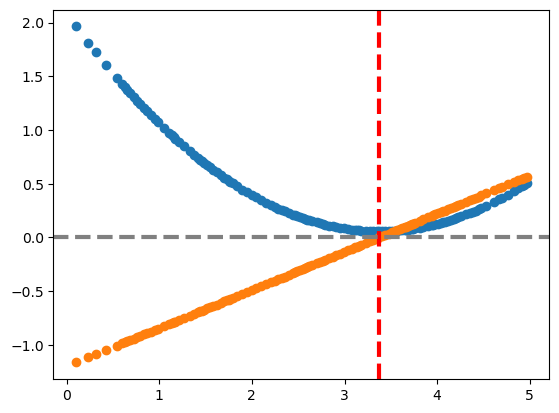

In [45]:
# plt.scatter(rModel.rmed, smooth(rModel.shmr_halo_mass, 10, deriv=1), label='SHMR - Zu & Mandelbaum et al. (2015)')
plt.scatter(rModel.rmed, smoothP(rModel.rmed,rModel.shmr_halo_mass, 3, deriv=1), label='SHMR - Zu & Mandelbaum et al. (2015)')
plt.scatter(rModel.rmed, smoothP(rModel.rmed,rModel.shmr_halo_mass, 3, deriv=2), label='SHMR - Zu & Mandelbaum et al. (2015)')

# plt.axvline(r200c, ls='--',lw=3, color='gray')
plt.axvline(fit_halo_mass_poly_derivative(rModel), ls='--',lw=3, color='r')
plt.axhline(0., ls='--',lw=3, color='gray')

# plt.axhline(-0.025, ls='--',lw=3, color='r')
# plt.axhline(+0.025, ls='--',lw=3, color='r')
# plt.yscale('log')

In [46]:
from scipy.signal import savgol_filter

from scipy import interpolate
def smooth(x, window=5, p=3, deriv=0):
    return savgol_filter(x, window, p, deriv=deriv)

def smoothP(x,y, window=3, deriv=0):
    x= np.log10(x)
    y = np.log10(y)
    idx = np.isfinite(x) & np.isfinite(y)
    coefs = np.polyfit(x[idx], y[idx], deg=window)
    xnew = np.arange(0., 4., 100)
    if deriv==0:
        return np.poly1d(coefs)(x)
    else:
        return np.poly1d(coefs).deriv(deriv)(x)

def cubicSpline(x,y,deriv=0):
    idx = np.isfinite(x) & np.isfinite(y)
    f2 = interpolate.CubicSpline(x, y) # Added
    return f2(x, deriv)

## Check Accuracy

In [47]:
keys = [np.where((gid==cid)& (rv<=5.0))[0] for cid in np.array(cat['Yang'])]

In [48]:
dx = 0.25
nobjects = []
r200p, m200p = [], []
for i,idx in enumerate(keys):
    #print('CID: %i'%cat['Yang'][i])
    #rbins = np.arange(0., 5+dx, dx)
    nbins =  int(idx.size/10)+1
    rbins = np.percentile(rv[idx], np.linspace(0,100, nbins))

    sbg = sigma_bkg[i] #compute_background_denstiy(idx)
    rModel = r200SHMR(rbins, model_name='zu_mandelbaum15', sigma_bg=sbg)
    rModel.fit(smass[idx], rv[idx], bias=0.14)
    nobjects.append(idx.size)
    r200p.append(rModel.r200c)
    m200p.append(rModel.m200c)
    
r200p = np.array(r200p)
m200p = np.array(m200p)
nobjects = np.array(nobjects)

In [49]:
m200c = np.array(cat['logM200c'])
r200c = convertM200toR200_z(10**cat['logM200c'], zcls)
redshift = np.array(cat['redshift'])

In [64]:
bias = np.median(m200p-m200c)
bias

-0.3164704625213588

In [68]:
def convertM200toR200_z(M200,z,delta=200):
    ## M200 in solar masses
    ## R200 in Mpc
    rhoc = (cosmo.critical_density(z).to(u.Msun/u.Mpc**3)).value # Msun/Mpc^3
    R200 = ( M200/(delta*4*np.pi*rhoc/3) )**(1/3.)
    return R200/0.7

r200p2 = convertM200toR200_z(10**(m200p-bias), redshift)*0.7

Text(0.5, 1.0, 'Bias Corrected')

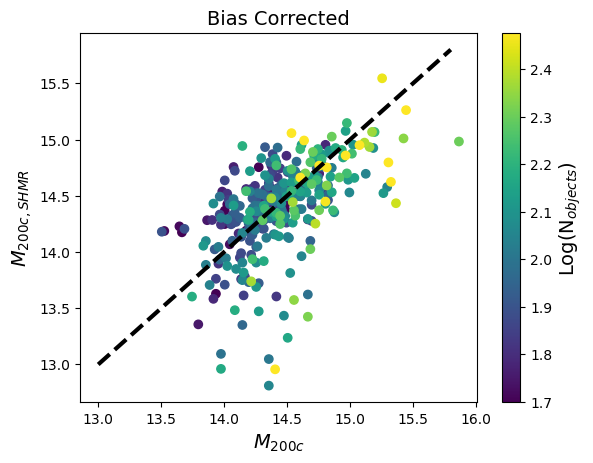

In [69]:
mmin, mmax = 13., 15.8
ix = np.argsort(nobjects)
plt.plot([mmin, mmax],[mmin, mmax],'k--',lw=3)
plt.scatter(m200c[ix], m200p[ix]-bias, c=np.log10(nobjects[ix]), vmin=np.log10(50), vmax=np.log10(300))
plt.colorbar().set_label('Log(N$_{objects}$)',fontsize=14)
plt.xlabel(r'$M_{200c}$',fontsize=14)
plt.ylabel(r'$M_{200c,SHMR}$',fontsize=14)
plt.title('Bias Corrected',fontsize=14)
# plt.ylim(mmin,mmax)
# plt.xlim(mmin,mmax)

(0.1, 4.2)

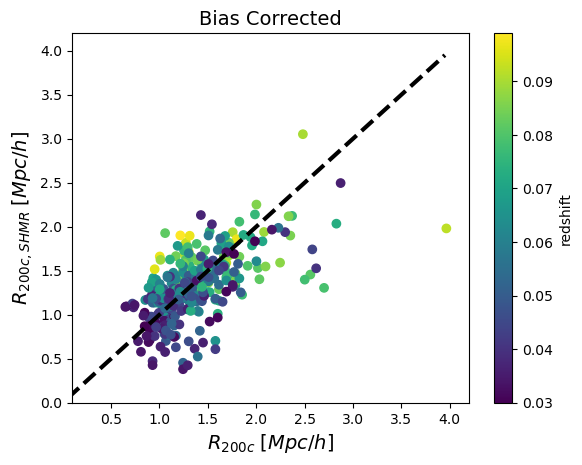

In [76]:
rmin, rmax = 0.05, 3.95
ix = np.argsort(nobjects)
plt.plot([rmin, rmax],[rmin, rmax],'k--',lw=3)
plt.scatter(r200c[ix], r200p2[ix], c=redshift[ix])
plt.colorbar().set_label('redshift')
plt.xlabel(r'$R_{200c} \; [Mpc/h]$',fontsize=14)
plt.ylabel(r'$R_{200c,SHMR}\; [Mpc/h]$',fontsize=14)
plt.title('Bias Corrected',fontsize=14)
plt.ylim(rmin-0.05,rmax+0.25)
plt.xlim(rmin+0.05,rmax+0.25)

0.2526286083894748


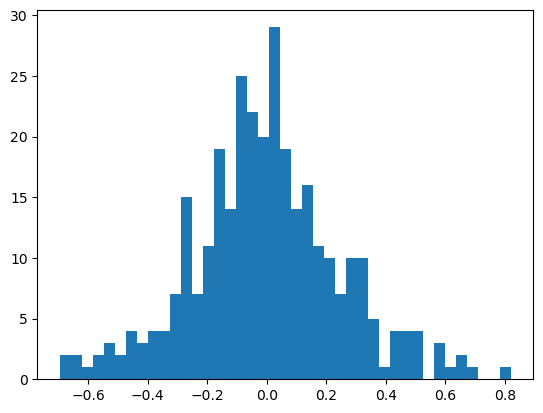

In [77]:
res = (r200p2-r200c)/r200c
nmask = redshift>0.
print(np.std(res[nmask]))
_ = plt.hist(res[nmask],bins=41)

Text(0.5, 1.0, 'True SHRM ')

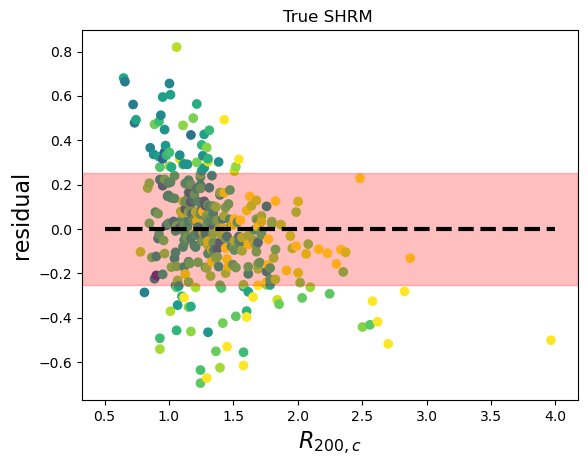

In [78]:
plt.plot([0.5, 4.],[0, 0],'k--',lw=3)
plt.scatter(r200c[nmask], res[nmask], c=np.log10(nobjects)[nmask],vmin=np.log10(20),vmax=np.log10(200))
plt.axhspan(-1*np.std(res[nmask]), 1*np.std(res[nmask]), alpha=0.25, color='r')
# plt.xscale('log')
plt.xlabel('$R_{200,c}$',fontsize=16)
plt.ylabel('residual',fontsize=16)
plt.title('True SHRM ')

In [79]:
cat[np.where( (np.abs(res)>0.25) & (r200c>3.1))[0]]

Yang,RA,DEC,redshift,N200,logM200c,logM200m,R200c,R200m,thetaR200,thetaR200m,vcirc_c,vcirc_m
int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64
413,255.6881,33.4648,0.09200000017881393,174,15.86490249633789,16.001098693222428,3.9000000953674316,4.968317796273429,0.44192655863053665,0.5629824539871574,2841.404296875,2615.7190065970285


In [57]:
r200p[cat['Yang']==45]

array([2.58282328])

In [58]:
r200c[cat['Yang']==45]

2.370868707132174


In [59]:
r200p

array([0.98607361, 1.04848985, 1.04690969, 1.1480398 , 0.96790179,
       0.53809881, 0.        , 0.84938994, 0.98765377, 0.78341834,
       1.50594559, 0.66490649, 1.119992  , 0.5459996 , 1.25154015,
       0.84069907, 0.83279828, 0.58313331, 0.85808081, 0.75655566,
       1.13381838, 0.86558656, 1.38427343, 0.        , 1.03150315,
       1.0840434 , 0.        , 1.54426443, 1.06547655, 1.28393339,
       1.58850885, 0.58313331, 0.72060706, 1.20255526, 1.42259226,
       1.49448945, 0.74588959, 1.38861886, 0.88731373, 1.23889889,
       1.13105311, 1.06626663, 1.14408941, 0.86163616, 1.31158616,
       1.23139314, 1.84844484, 1.79669467, 1.19386439, 0.44565957,
       0.66727673, 1.14922492, 1.3459546 , 1.1219672 , 1.19386439,
       1.19188919, 1.24442944, 0.94854485, 0.83872387, 0.32793779,
       2.22926293, 0.79052905, 1.09470947, 0.73719872, 0.63883388,
       0.65937594, 0.61908191, 0.71665667, 1.41587659, 1.09431443,
       1.45972597, 1.09628963, 1.03071307, 1.07811781, 0.61789

In [60]:
from scipy.optimize import curve_fit

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def mymodel(x,c,d):
    return (1-c-d)*(x) + c*x**2 + d*x**3

def fit_mymodel(x,y):
    x = sigmoid(x)
    y = y/y[-1]
    idx = np.isfinite(x) & np.isfinite(y)
    
    pfit, pcov = curve_fit(mymodel, x[idx], y[idx])
    return mymodel(x, *pfit)
def fit_mymodel(x,y):
    x = sigmoid(x)
    y = y/y[-1]
    idx = np.isfinite(x) & np.isfinite(y)
    
    pfit, pcov = curve_fit(piecewise_mymodel, x[idx], y[idx])
    return piecewise_mymodel(x, *pfit)

def piecewise_mymodel(x,c,d,y0,k1,xmin):
    return np.piecewise(x, [x < xmin], [lambda x:mymodel(x,c,d)+y0-k1*xmin, lambda x:k1*x+y0-mymodel(xmin,c,d)])


In [61]:
# def smooth(x, window=5, p=3, deriv=0):
smooth(rModel.shmr_halo_mass/rModel.shmr_halo_mass[-1], window=7, p=3)

array([0.91504593, 0.9424598 , 0.95877412, 0.96718556, 0.97105423,
       0.97444316, 0.97661828, 0.9789732 , 0.98144004, 0.98381236,
       0.98548479, 0.98700074, 0.98873215, 0.99073321, 0.99279038,
       0.99457825, 0.99590429, 0.99734424, 0.99871039, 0.99998348])

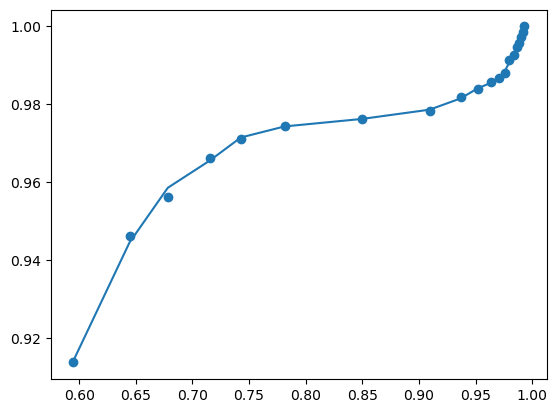

In [62]:
plt.scatter(sigmoid(rModel.rmed),rModel.shmr_halo_mass/rModel.shmr_halo_mass[-1])

xnew = np.linspace(0.5,1.0)
plt.plot(sigmoid(rModel.rmed),smooth(rModel.shmr_halo_mass/rModel.shmr_halo_mass[-1]))

# plt.plot(sigmoid(rModel.rmed),fit_mymodel(rModel.rmed,rModel.shmr_halo_mass))

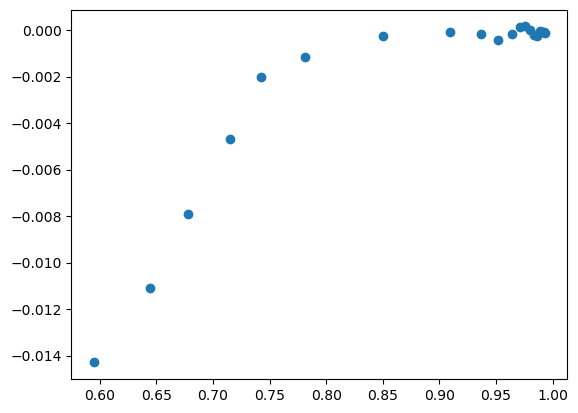

In [63]:
plt.scatter(sigmoid(rModel.rmed),smooth(rModel.shmr_halo_mass/rModel.shmr_halo_mass[-1],window=7,deriv=2))

In [ ]:
highest_order_polynomial = 3
 
# We have our data now, so on with the tensorflow
# Setup the model graph
 
# Our input is an arbitrary number of data points (That's what the 'None dimension means)
# and each input has just a single value which is a float
 
X = tf.placeholder(tf.float32, [None])
Y = tf.placeholder(tf.float32, [None])
 
# Now, we know data fits a CDF function, so we know that
# ys(-inf) = 0   and ys(+inf) = 1
 
# So let's set:
 
X2 = tf.sigmoid(X)
 
def mymodel(x,c,d):
    return (1-c-d)*(x) + c*x**2 + d*x**3

# So now X2 is between [0,1]
 
# Let's now fit a polynomial like:
#
#   Y = a + b*(X2) + c*(X2)^2 + d*(X2)^3 + .. + z(X2)^(highest_order_polynomial)
#
# to those points.  But we know that since it's a CDF:
#   Y(0) = 0 and y(1) = 1
#
# So solving for this:
#   Y(0) = 0 = a
#   b = (1-c-d-e-...-z)
#
# This simplifies our function to:
#
#   y = (1-c-d-e-..-z)x + cx^2 + dx^3 + ex^4 .. + zx^(highest_order_polynomial)
#
# i.e. we have highest_order_polynomial-2  number of weights
W = tf.Variable(tf.zeros([highest_order_polynomial-1]))
 
# Now set up our equation:
Y_pred = tf.Variable(0.0)
b = (1 - tf.reduce_sum(W))
Y_pred = tf.add(Y_pred, b * tf.sigmoid(X2))
 
for n in xrange(2, highest_order_polynomial+1):
    Y_pred = tf.add(Y_pred, tf.mul(tf.pow(X2, n), W[n-2]))
 
# Loss function measure the distance between our observations
# and predictions and average over them.
cost = tf.reduce_sum(tf.pow(Y_pred - Y, 2)) / (n_observations - 1)
 
# Regularization if we want it.  Only needed if we have a large value for the highest_order_polynomial and are worried about overfitting
# It's also not clear to me if regularization is going to be doing what we want here
#cost = tf.add(cost, regularization_value * (b + tf.reduce_sum(W)))
 
# Use stochastic gradient descent to optimize W
# using adaptive learning rate
optimizer = tf.train.AdagradOptimizer(100.0).minimize(cost)
 
n_epochs = 10000
with tf.Session() as sess:
    # Here we tell tensorflow that we want to initialize all
    # the variables in the graph so we can use them
    sess.run(tf.initialize_all_variables())
 
    # Fit all training data
    prev_training_cost = 0.0
    for epoch_i in range(n_epochs):
        sess.run(optimizer, feed_dict={X: xs, Y: ys})
 
        training_cost = sess.run(
            cost, feed_dict={X: xs, Y: ys})
 
        if epoch_i % 100 == 0 or epoch_i == n_epochs-1:
            print(training_cost)
 
        # Allow the training to quit if we've reached a minimum
        if np.abs(prev_training_cost - training_cost) &amp;lt; 0.0000001:
            break
        prev_training_cost = training_cost
    print &quot;Training cost: &quot;, training_cost, &quot; after epoch:&quot;, epoch_i
    w = W.eval()
    b = 1 - np.sum(w)
    equation = &quot;x' = sigmoid(x), y = &quot;+str(b)+&quot;x' +&quot; + (&quot; + &quot;.join(&quot;{}x'^{}&quot;.format(val, idx) for idx, val in enumerate(w, start=2))) + &quot;)&quot;;
    print &quot;For function:&quot;, equation
    pred_values = Y_pred.eval(feed_dict={X: xs}, session=sess)
    ax.plot(xs, pred_values, 'r')
    plt.title(equation)
 
fig.show()
plt.draw()
#ax.set_ylim([-3, 3])
plt.waitforbuttonpress()